In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
from sympy import integrate, exp, sin, log, oo, pi,symbols
import deepxde as dde
import scipy.io as scio
from mpl_toolkits.mplot3d import Axes3D
from deepxde.backend import tf
#import datetime
import time
import os
from pylab import mpl
from scipy.signal import chirp, spectrogram
mpl.rcParams['font.sans-serif']=['Microsoft YaHei']
mpl.rcParams['axes.unicode_minus']=False
from matplotlib.pyplot import MultipleLocator
# import xlrd
# import xlwt
from sympy import *
import sympy as sp
# import torch

2024-10-28 15:13:19.671600: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term


2024-10-28 15:13:20.480740: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-28 15:13:20.484312: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-28 15:13:20.484418: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Enable just-in-time compilation with XLA.




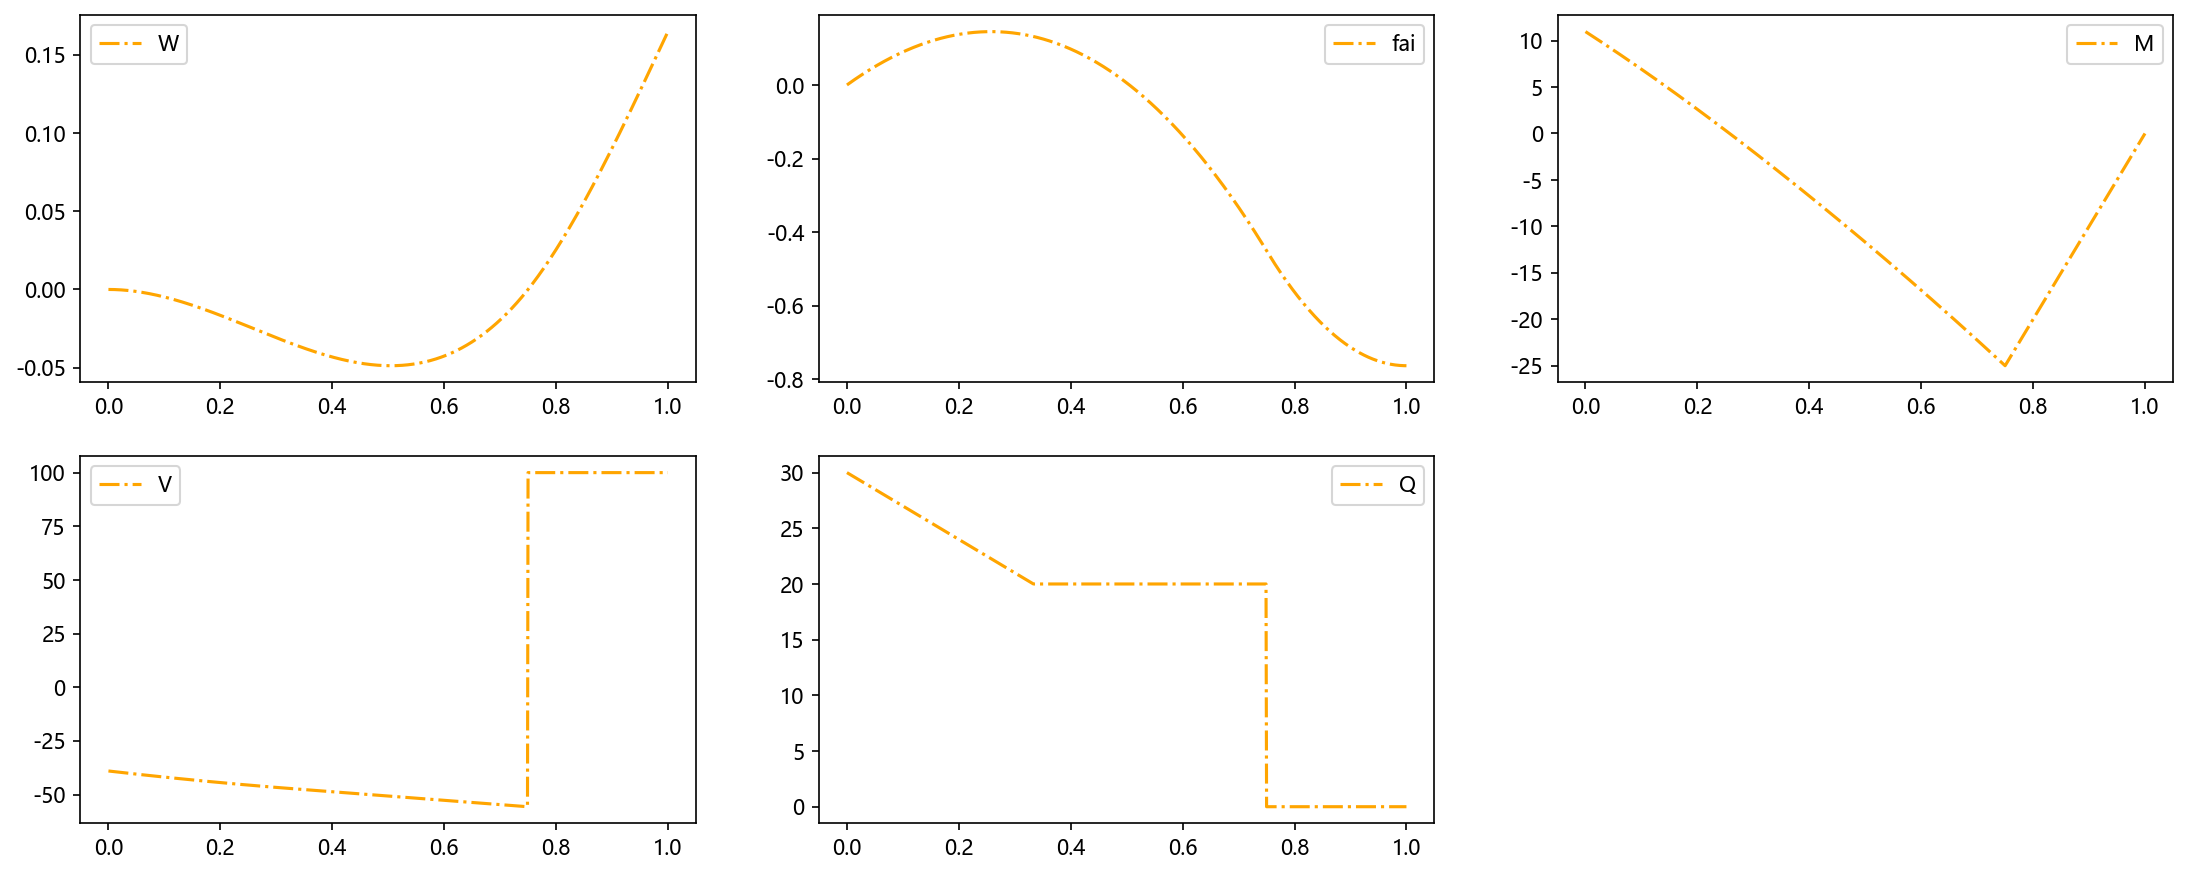

In [4]:
def Output(X):
    import re
    lines = open("s1.dat", "r").readlines()
    S = np.array([np.fromstring(min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line),\
                                key=len),sep=",",) for line in lines ])
    dis = S[:,0:num_dis+2][-1]
    interv = [ (X>=dis[i])&(X<dis[i+1]) for i in range(0,dis.shape[0]-1) ]
    out_all = model.predict(X)
    Y = out_all[:, 2: 4*num_NN-num_NN2]
    Out = Y[:,0::num_NN][interv[0].ravel()]
    for i in range(1,num_NN):
        Out = np.vstack((Out, Y[:,i::num_NN][interv[i].ravel()]))
    Out = np.hstack((out_all[:,0:2],Out))
    return [Out[:,i:i+1] for i in range(0,4)]

def Output_dNN(X, j = 0):
    import re
    lines = open("s1.dat", "r").readlines()
    S = np.array([np.fromstring(min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line),\
                                key=len),sep=",",) for line in lines ])
    dis = S[:,0:num_dis+2][-1]
    if j == 0:
        Out_dNN = model.predict(X, operator=lambda x,y:dde.grad.jacobian(y,x, i=j,j=0))
        return -Out_dNN
    if j ==1:
        Out_dNN = model.predict(X, operator=lambda x,y:dde.grad.jacobian(y,x, i=j,j=0))
        return Out_dNN
    interv = [ (X>=dis[i])&(X<dis[i+1]) for i in range(0,dis.shape[0]-1) ]
    Out_dNN = model.predict(X[interv[0].ravel()], operator=lambda x,y:dde.grad.jacobian(y,x, i=num_NN*j-num_NN2,j=0))
    for i in range(1,num_NN):
        Out_dNN = np.vstack((Out_dNN,model.predict(X[interv[i].ravel()], operator=\
                                               lambda x,y:dde.grad.jacobian(y,x, i=num_NN*j+i-num_NN2,j=0)) ))
    if j == 0 or j == 3: #u,fai,M,V   fai_dNN,dfai_dNN,XXX,V_dNN,q_dNN
        Out_dNN = -Out_dNN
    return Out_dNN

def Norm_exact(P = 0):
    import re
    lines = open("s1.dat", "r").readlines()
    S = np.array([np.fromstring(min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line),\
                                key=len),sep=",",) for line in lines ])
    dis = S[:,0:num_dis+2][-1]
    X = X1
    W,fai,M,V = Output(X)
    Q = [Output_dNN(X, j = i) for i in [3]][0]
    EI_exact = NP_EI(X)
    EI = EI_exact
    norm_w = np.linalg.norm(W-WW1,ord=2) / np.linalg.norm(WW1,ord=2)
    norm_fai = np.linalg.norm(fai-dWW1,ord=2) / np.linalg.norm(dWW1,ord=2)
    norm_M = np.linalg.norm(M-ddWW1,ord=2) / np.linalg.norm(ddWW1,ord=2)
    norm_V = np.linalg.norm(V-dddWW1,ord=2) / np.linalg.norm(dddWW1,ord=2)
    norm_Q = np.linalg.norm(Q-ddddWW1,ord=2) / np.linalg.norm(ddddWW1,ord=2)
    norm_EI = np.linalg.norm(EI-EI_exact,ord=2) / np.linalg.norm(EI_exact,ord=2)
    norm = np.hstack((norm_w,norm_fai,norm_M,norm_V,norm_Q))
    Norm = np.hstack((np.array(dis[1:num_dis+1]),norm))
    print(Norm)
    if P == 1:
        return Norm, [W,fai,M,V,Q]
    return Norm

def Norm_NN( X, P = 0):
    u,fai,M,V = Output(X)
    fai_dNN,dfai_dNN,V_dNN,Q_dNN = [Output_dNN(X, j = i) for i in [0,1,2,3]]
    Q = Q_dNN
    M_dNN = dfai_dNN*EI
    EI_exact = NP_EI(X)
    norm_fai_dNN = np.linalg.norm(fai-fai_dNN,ord=2) / np.linalg.norm(fai_dNN,ord=2)
    norm_M_dNN = np.linalg.norm(M-M_dNN,ord=2) / np.linalg.norm(M_dNN,ord=2)
    norm_V_dNN = np.linalg.norm(V-V_dNN,ord=2) / np.linalg.norm(V_dNN,ord=2)
    norm_Q_dNN = np.linalg.norm(Q_dNN-NP_Q(X),ord=2) / np.linalg.norm(NP_Q(X),ord=2)
    norm_EI = np.linalg.norm(EI-EI_exact,ord=2) / np.linalg.norm(EI_exact,ord=2)
    Norm = np.hstack((norm_fai_dNN,norm_M_dNN,norm_V_dNN,norm_Q_dNN))
    print('norm_fai_dNN,norm_M_dNN,norm_V_dNN,norm_Q_dNN')
    print(Norm)
    if P == 1:
        return Norm,[u,fai,M,V,Q],[fai_dNN,dfai_dNN,V_dNN,Q_dNN]
    return Norm

def Plot_dis():
    import re
    lines = open("s1.dat", "r").readlines()
    S = np.array(
        [
            np.fromstring(
                min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
                sep=",",
            )
            for line in lines
        ]
    )
    markersize = 10
    markevery = 50
    plt.figure()
    l = S.shape[0]
    width, height, dpi = 3.35, 2.1, 200
    plt.figure(figsize=(width,height),dpi = dpi)
    markersize = 2
    markevery = 20
    plt.plot(range(0, 200 * l, 200), S[:,1:2], linestyle='dashed',alpha=0.7,linewidth=0.7, \
             marker='^',markersize=markersize,markevery=markevery, label="$s^1$",color='orange')
    plt.plot(range(0, 200 * l, 200), S[:,2:3], linestyle='dashed',alpha=0.7,linewidth=0.7, \
             marker='v',markersize=markersize,markevery=markevery, label="$s^2$",color='lightcoral')
    # plt.plot(range(0, 200 * l, 200), S[:,3:4], linestyle='dashed',alpha=0.7,linewidth=0.7, \
    #          marker='o',markersize=markersize,markevery=markevery, label="$s^3$",color='c')
    plt.plot(range(0, 200 * l, 200), S[:,0:1]*0+1/3,linewidth=0.7, label="$exact$",color='green')
    plt.plot(range(0, 200 * l, 200), S[:,0:1]*0+0.75,linewidth=0.7, label="$exact$",color='#004B8B')
    # plt.plot(range(0, 200 * l, 200), S[:,0:1]*0+0.65,linewidth=0.7, label="$exact$",color='purple')
    plt.tick_params(width=0.5, labelsize=6)
    plt.xlabel('Epoch', fontsize=7)
    plt.legend(fontsize=6,frameon=False,bbox_to_anchor=(0.5, 0.35), ncol=2)
    plt.savefig('ex3_s.png',bbox_inches='tight', dpi=800)
    plt.show()
    data_s = np.hstack((np.array([range(0, 200 * l, 200)]).reshape(-1,1),S))
    print(S[-1])
%run Solution_ex2.ipynb

In [5]:
d1 = 1/3
d2 = 0.75
s0 = tf.Variable(-0.1, trainable=False, dtype=tf.float32)
s1 = tf.Variable(0.1, trainable=True, dtype=tf.float32)
s2 = tf.Variable(0.75, trainable=False, dtype=tf.float32)
s_end = tf.Variable(L+0.1, trainable=False, dtype=tf.float32)
SS = [s0,s1,s2,s_end]

SS_fig = [-SS[1],s1,s2,2*L-SS[-2]]

num_dis = len(SS)-2
num_NN = num_dis+1

num_NN2 = 2*(num_NN-1)

CC = []
for i in range(3):
    CC.append(tf.Variable(0, trainable=True, dtype=tf.float32))
VV = SS.copy() 
VV.extend(CC)
c1 = CC[0]
c2 = CC[1]
c3 = CC[2]

Compiling model...
Building feed-forward neural network...
'build' took 0.040971 s



/home/pms/anaconda3/envs/tensorflow/lib/python3.9/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2024-10-28 15:13:22.023566: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-28 15:13:22.024388: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-28 15:13:22.024515: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must 

'compile' took 5.968608 s



2024-10-28 15:13:28.044287: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2024-10-28 15:13:28.239996: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x7f95d40194f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-28 15:13:28.240014: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2024-10-28 15:13:28.249802: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-10-28 15:13:28.249811: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2024-10-28 15:13:28.249962: I tensorflow/compiler/jit/xla_compilation_cache.cc:478] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Training model...



2024-10-28 15:13:29.040617: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:263] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-28 15:13:29.513437: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-10-28 15:13:29.515721: W tensorflow/compiler/xla/service/gpu/buffer_comparator.cc:640] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Setting XLA_FLAGS=--xla_gpu_cuda_data_dir=/path/to/cuda  or modifying $PATH can be used to set the location of ptxas
This message will only be logged once.


Step      Train loss                                            Test loss                                             Test metric
0         [8.64e-03, 8.74e+00, 5.30e+02, 2.55e+02, 7.09e+01]    [8.64e-03, 8.74e+00, 5.30e+02, 2.55e+02, 7.09e+01]    []  
1000      [2.10e-02, 4.80e-01, 1.85e+02, 1.25e+00, 8.33e-01]    [2.10e-02, 4.80e-01, 1.85e+02, 1.25e+00, 8.33e-01]    []  
2000      [9.70e-02, 2.16e-01, 5.03e+01, 4.10e-01, 1.92e-01]    [9.70e-02, 2.16e-01, 5.03e+01, 4.10e-01, 1.92e-01]    []  
3000      [1.64e-01, 3.58e-02, 1.29e+01, 1.09e-01, 3.39e-02]    [1.64e-01, 3.58e-02, 1.29e+01, 1.09e-01, 3.39e-02]    []  
4000      [2.00e-01, 1.33e-02, 5.08e+00, 3.09e-02, 2.56e-02]    [2.00e-01, 1.33e-02, 5.08e+00, 3.09e-02, 2.56e-02]    []  
5000      [2.10e-01, 1.15e-02, 2.05e+00, 1.06e-02, 3.34e-02]    [2.10e-01, 1.15e-02, 2.05e+00, 1.06e-02, 3.34e-02]    []  
6000      [2.00e-01, 1.18e-02, 4.97e-01, 2.15e-03, 7.37e-03]    [2.00e-01, 1.18e-02, 4.97e-01, 2.15e-03, 7.37e-03]    []  
7000     

<Figure size 640x480 with 0 Axes>

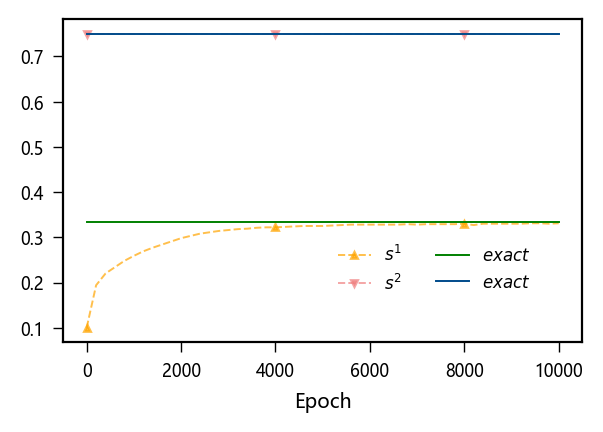

[-0.1    0.331  0.75   1.1   -0.815 -2.5   -3.59 ]


In [6]:
K = 1234
np.random.seed(K)
tf.set_random_seed(K)

num_domain = 0
epochs = 10000
lr = 1e-3
u_nodenum=20
u_layer=2

activation_func1 = tf.nn.tanh
activation_func2 = tf.nn.elu

l = 0.75
a = 0.25
A = 0.05*0.012
I = 0.012*0.05**3/12
E = 1e4/I*0.001
EI = E*I
EI_real = EI
L = 1.
F= 100.
anchors_x = np.linspace(0,L,201).reshape(-1,1)

def f_sig0(x_in,i):
    cond1 = tf.logical_and(tf.greater_equal(x_in, SS[i]), tf.less(x_in, SS[i+1]))
    f1 = tf.ones_like(x_in)
    f2 = tf.zeros_like(x_in)
    f = tf.where(cond1, f1, f2)
    return f

def f(x_in):
    cond1 = tf.logical_and(tf.greater_equal(x_in, 0), tf.less(x_in, 1/3))
    f1 = 30 - 30 * x_in
    cond2 = tf.logical_and(tf.greater_equal(x_in, 1/3), tf.less(x_in, 3/4))
    f2 = 20 * tf.ones_like(x_in)
    cond3 = tf.logical_and(tf.greater_equal(x_in, 3/4), tf.less_equal(x_in, 1))
    f3 = tf.zeros_like(x_in)
    f = tf.where(cond1, f1, tf.where(cond2, f2, f3))
    return f

def g(x_in):
    cond1 = tf.logical_and(tf.greater_equal(x_in, 0), tf.less(x_in, 1/3))
    f1 = - 30*tf.ones_like(x_in)
    cond2 = tf.logical_and(tf.greater_equal(x_in, 1/3), tf.less_equal(x_in, 1))
    f2 = tf.zeros_like(x_in)
    f = tf.where(cond1, f1, f2)
    return f

def NP_Q(x_in):
    cond1 = np.logical_and(np.greater_equal(x_in, 0), np.less(x_in, 1/3))
    f1 = 30 - 30 * x_in
    cond2 = np.logical_and(np.greater_equal(x_in, 1/3), np.less(x_in, 3/4))
    f2 = 20 * np.ones_like(x_in)
    cond3 = np.logical_and(np.greater_equal(x_in, 3/4), np.less_equal(x_in, 1))
    f3 = np.zeros_like(x_in)
    f = np.where(cond1, f1, np.where(cond2, f2, f3))
    return f

def TF_EI(x_in):
    f1 = 10*tf.ones_like(x_in)
    return f1

def NP_EI(x_in):
    f1 = 10*np.ones_like(x_in)
    return f1

def beampde_err(x, y):
    x_in = x[:,0:1]
    u    = y[:,0  :1]
    Fai  = y[:,1  :2]
    M    = y[:,num_NN*0+2:num_NN*1+2]
    V    = y[:,num_NN*1+2:num_NN*2+2]

    Fai_dNN = []
    M_dNN = []
    V_dNN = []
    Q_dNN = []
    DEI_dNN = []
    dQ_dNN = []
    
    fai_dNN = -dde.grad.jacobian(u, x, i = 0, j=0)
    dfai_dNN =  dde.grad.jacobian(Fai, x, i = 0, j=0) 
    m_dNN = EI_real * dfai_dNN
    
    for i in range(num_NN):
        v_dNN = dde.grad.jacobian(M, x, i = i, j=0)
        q_dNN = -dde.grad.jacobian(V, x, i = i, j=0)
        dq_dNN = dde.grad.jacobian(q_dNN, x, i = 0, j=0)
        # Fai_dNN.append(fai_dNN)
        # M_dNN.append(m_dNN)
        V_dNN.append(v_dNN)
        Q_dNN.append(q_dNN)
        dQ_dNN.append(dq_dNN)
    f_sig = []
    for i in range(num_NN):
        f_sig.append( 10*tf.keras.activations.relu((x_in-SS_fig[i])) \
                     * tf.keras.activations.relu((-x_in+SS_fig[i+1])) )
    # f_sig.append(10*tf.keras.activations.relu(-x_in+s1))
    # f_sig.append(10*tf.keras.activations.relu(x_in-s1))
    loss_Fai = 0
    loss_M = 0
    loss_V = 0
    loss_Q = 0
    loss_dQ = 0
    loss_Fai = loss_Fai + (Fai - fai_dNN)
    for i in range(num_NN):
        loss_M = loss_M + (M[:,i:i+1]-m_dNN   )               * f_sig0(x_in,i)
        loss_V = loss_V + (V[:,i:i+1]-V_dNN[i])               * f_sig0(x_in,i)
        loss_Q = loss_Q + (f(x_in)-Q_dNN[i])                  * f_sig0(x_in,i)
        loss_dQ = loss_dQ + (g(x_in)-dQ_dNN[i])               * f_sig[i]
    return [loss_Fai,
            loss_M,\
            loss_V,
            loss_Q,loss_dQ]

def beampde2(x, y):
    x_in = x[:,0:1]
    u    = y[:,0  :1]
    Fai  = y[:,1  :2]
    M    = y[:,num_NN*0+2:num_NN*1+2]
    V    = y[:,num_NN*1+2:num_NN*2+2]

    Fai_dNN = []
    M_dNN = []
    V_dNN = []
    Q_dNN = []
    DEI_dNN = []
    dQ_dNN = []
    
    fai_dNN = -dde.grad.jacobian(u, x, i = 0, j=0)
    dfai_dNN =  dde.grad.jacobian(Fai, x, i = 0, j=0) 
    m_dNN = EI_real * dfai_dNN
    
    for i in range(num_NN):
        v_dNN = dde.grad.jacobian(M, x, i = i, j=0)
        q_dNN = -dde.grad.jacobian(V, x, i = i, j=0)
        dq_dNN = dde.grad.jacobian(q_dNN, x, i = 0, j=0)
        # Fai_dNN.append(fai_dNN)
        # M_dNN.append(m_dNN)
        dQ_dNN.append(dq_dNN)
        V_dNN.append(v_dNN)
        Q_dNN.append(q_dNN)
    f_sig = []
    for i in range(num_NN):
        f_sig.append( 10*tf.keras.activations.relu((x_in-SS_fig[i])) \
                     * tf.keras.activations.relu((-x_in+SS_fig[i+1])) )
    # f_sig.append(10*tf.keras.activations.relu(-x_in+s1))
    # f_sig.append(10*tf.keras.activations.relu(x_in-s1))
    loss_Fai = 0
    loss_M = 0
    loss_V = 0
    loss_Q = 0
    loss_dQ = 0
    
    loss_Fai = loss_Fai + (Fai - fai_dNN)
    for i in range(num_NN):
        loss_M = loss_M + (M[:,i:i+1]-m_dNN   )               * f_sig[i] 
        loss_V = loss_V + (V[:,i:i+1]-V_dNN[i])               * f_sig[i]
        loss_Q = loss_Q + (f(x_in)-Q_dNN[i])                  * f_sig[i]
        loss_dQ = loss_dQ + (g(x_in)-dQ_dNN[i])               * f_sig[i]
    return [loss_Fai,
            loss_M,\
            loss_V,
            loss_Q,
            loss_dQ]

geom = dde.geometry.Interval(0, L)
data = dde.data.TimePDE(geom,beampde2,[], num_domain=num_domain,anchors=anchors_x)

net = dde.maps.FNN([1]  + [50]*3 + [num_NN*2+2], "tanh", "Glorot uniform")

def modify_output(X, y):
    x = X[:,0:1]
    u    = y[:,0  :1]
    Fai  = y[:,1  :2]
    M    = y[:,num_NN*0+2:num_NN*1+2]
    V    = y[:,num_NN*1+2:num_NN*2+2]

    final_output = tf.concat([u[:,0:1]*x*(x-l),\
                              Fai[:,0:1]*x, \
                              M[:,0:1]*(x-s1) +  10*c1, \
                              M[:,1:2]*(x-s1)*(x-s2) + 10*c1*(x-s2)/(s1-s2)+10*c2*(x-s1)/(s2-s1),\
                              M[:,2:3]*(x-s2)*(x-L) + 10*c2*(x-L)/(s2-L),\
                              10*V[:,0:1]*(x-s1)+10*c3,\
                              10*V[:,1:2]*(x-s1)+10*c3,\
                              10*V[:,2:3]*(x-L)+100], axis=1)
    return final_output

net.apply_output_transform(modify_output)
variable = dde.callbacks.VariableValue(VV, period=200, filename="s1.dat")#200为epochs之间的间隔
model = dde.Model(data, net)

loss = []
Weight = np.ones(5)
Weight[-1] = 1
for i in range(5):
    loss.append('MSE')

model.compile("adam", lr, loss_weights=list(Weight.ravel()), loss = loss)
losshistory, train_state = model.train(epochs=10000, callbacks=[variable])
list_reslut = Norm_exact()
List_weight = []
list_point = []
list_Norm_dNN = []
list_NN =[]
list_dNN =[]
Norm_dNN,[u,fai,M,V,Q],[fai_dNN,dfai_dNN,V_dNN,Q_dNN] = Norm_NN(X1, P = 1)
list_Norm_dNN.append(Norm_dNN)
list_NN.append(np.array([u,fai,M,V,Q]).reshape(5,-1).T)
list_dNN.append(np.array([fai_dNN,dfai_dNN,V_dNN,Q_dNN]).reshape(4,-1).T)
np.savetxt('1.txt', list_reslut)
Plot_dis()

Weight [1.         0.17888025 0.00482674 0.00168065 1.        ]
Compiling model...
'compile' took 7.334083 s

Mean residual: 1.292e-01
Adding new point: [[0.74997959]] 

Adding new point: [[0.74980275]] 

Adding new point: [[0.74976931]] 

Adding new point: [[0.74967785]] 

Adding new point: [[0.74963457]] 

Adding new point: [[0.74946214]] 

Adding new point: [[0.7493459]] 

Adding new point: [[0.74930132]] 

Adding new point: [[0.74925439]] 

Adding new point: [[0.74923756]] 

Adding new point: [[0.74899211]] 

Adding new point: [[0.74826288]] 

Adding new point: [[0.74807159]] 

Adding new point: [[0.74788682]] 

Adding new point: [[0.75009935]] 

Adding new point: [[0.75017754]] 

Adding new point: [[0.7477531]] 

Adding new point: [[0.75022772]] 

Adding new point: [[0.7477012]] 

Adding new point: [[0.74769965]] 



2024-10-28 15:14:12.221415: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1750] (One-time warning): Not using XLA:CPU for cluster.

If you want XLA:CPU, do one of the following:

 - set the TF_XLA_FLAGS to include "--tf_xla_cpu_global_jit", or
 - set cpu_global_jit to true on this session's OptimizerOptions, or
 - use experimental_jit_scope, or
 - use tf.function(jit_compile=True).

To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a
proper command-line flag, not via TF_XLA_FLAGS).


Training model...

Step      Train loss                                            Test loss                                             Test metric
10000     [3.12e-02, 1.85e-03, 1.40e-06, 4.83e-08, 8.05e-05]    [3.32e-02, 2.02e-03, 1.54e-06, 5.02e-08, 1.26e-04]    []  
11000     [1.69e-02, 2.47e-03, 7.62e-04, 3.56e-05, 1.12e-04]    [1.83e-02, 2.68e-03, 8.38e-04, 3.86e-05, 1.33e-04]    []  
12000     [1.07e-02, 2.16e-03, 1.16e-03, 6.24e-05, 2.00e-03]    [1.16e-02, 2.33e-03, 1.28e-03, 6.78e-05, 2.35e-03]    []  
13000     [6.53e-03, 2.03e-03, 1.34e-03, 9.19e-05, 5.96e-05]    [7.05e-03, 2.21e-03, 1.47e-03, 1.01e-04, 8.63e-05]    []  
14000     [3.88e-03, 1.88e-03, 1.43e-03, 1.10e-04, 4.57e-05]    [4.18e-03, 2.06e-03, 1.57e-03, 1.21e-04, 6.21e-05]    []  
15000     [2.26e-03, 1.79e-03, 1.39e-03, 1.10e-04, 3.87e-05]    [2.44e-03, 1.98e-03, 1.52e-03, 1.21e-04, 7.40e-05]    []  
16000     [1.35e-03, 1.73e-03, 1.17e-03, 9.29e-05, 3.49e-05]    [1.44e-03, 1.93e-03, 1.29e-03, 1.02e-04, 4.26e-05

2024-10-28 15:14:35.774159: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


norm_fai_dNN,norm_M_dNN,norm_V_dNN,norm_Q_dNN
[0.0376487  0.06616188 0.01299153 0.01290995]
[0.33       0.75       0.01570048 0.03710581 0.02621351 0.02602041
 0.01291639]


<Figure size 640x480 with 0 Axes>

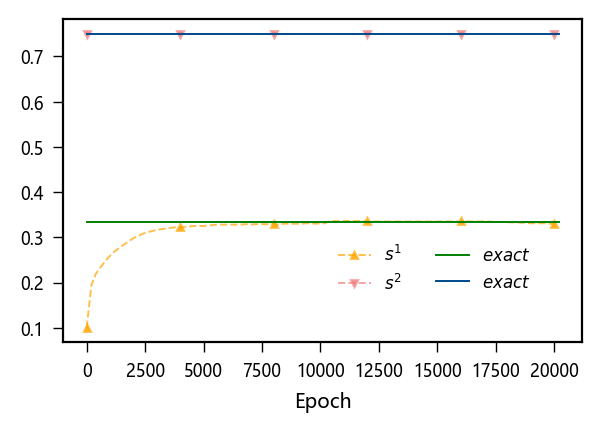

[-0.1    0.33   0.75   1.1   -0.362 -2.48  -4.53 ]
Weight [0.56903922 1.         0.19635971 0.19512668 1.        ]
Compiling model...
'compile' took 9.361267 s

Mean residual: 2.434e-01
Adding new point: [[0.75008379]] 

Adding new point: [[0.75024363]] 

Adding new point: [[0.75035198]] 

Adding new point: [[0.75043975]] 

Adding new point: [[0.75053802]] 

Adding new point: [[0.7505512]] 

Adding new point: [[0.7505759]] 

Adding new point: [[0.75060272]] 

Adding new point: [[0.75061566]] 

Adding new point: [[0.75072665]] 

Adding new point: [[0.75073707]] 

Adding new point: [[0.75080626]] 

Adding new point: [[0.75093212]] 

Adding new point: [[0.75095183]] 

Adding new point: [[0.75095426]] 

Adding new point: [[0.75098664]] 

Adding new point: [[0.75107721]] 

Adding new point: [[0.75112039]] 

Adding new point: [[0.75130317]] 

Adding new point: [[0.7513304]] 

Training model...

Step      Train loss                                            Test loss                         

<Figure size 640x480 with 0 Axes>

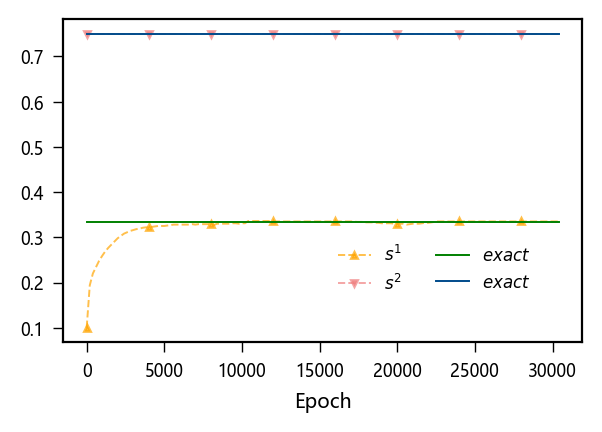

[-0.1    0.335  0.75   1.1   -0.367 -2.5   -4.72 ]
Weight [0.35887561 1.         0.01596692 0.00351313 1.        ]
Compiling model...
'compile' took 11.308689 s

Mean residual: 6.544e-02
Adding new point: [[0.75000459]] 

Adding new point: [[0.75011934]] 

Adding new point: [[0.7501856]] 

Adding new point: [[0.75032105]] 

Adding new point: [[0.75057555]] 

Adding new point: [[0.75058238]] 

Adding new point: [[0.75081025]] 

Adding new point: [[0.75089859]] 

Adding new point: [[0.75097954]] 

Adding new point: [[0.75099487]] 

Adding new point: [[0.75103516]] 

Adding new point: [[0.75108623]] 

Adding new point: [[0.75118882]] 

Adding new point: [[0.75120077]] 

Adding new point: [[0.75120496]] 

Adding new point: [[0.75127962]] 

Adding new point: [[0.75129567]] 

Adding new point: [[0.75130393]] 

Adding new point: [[0.75136831]] 

Adding new point: [[0.75144944]] 

Training model...

Step      Train loss                                            Test loss                      

<Figure size 640x480 with 0 Axes>

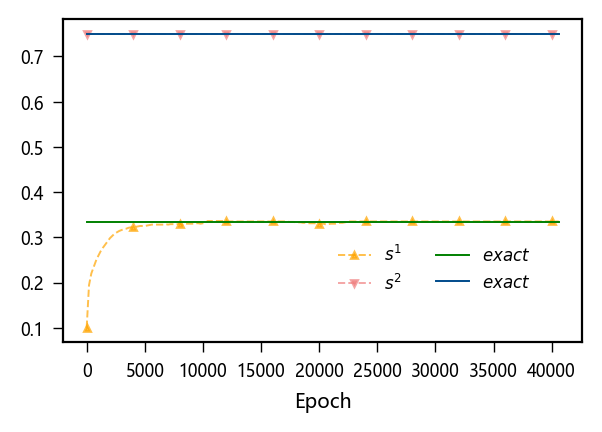

[-0.1    0.335  0.75   1.1   -0.372 -2.49  -4.7  ]


In [7]:
for i in range(3):
    Weight = np.hstack((Norm_dNN/np.max(Norm_dNN),1))
    print('Weight',Weight)
    model.compile("adam", 1e-4, loss_weights=list(Weight.ravel()), loss = loss)
    X = np.random.uniform(0,L,10000)
    X = np.sort(X,axis = 0).reshape(-1,1)
    err_total = np.abs(model.predict(X, operator=beampde_err))  #计算前6项残差
    err_eq = np.sum(err_total,axis=0)             #每项残差除以均值进行缩放，每个点，残差求和
    print("Mean residual: %.3e" % (np.mean(err_total)))
    x_ids = np.argsort(-err_eq,axis=0 )[:20]
    for elem in x_ids:
        print("Adding new point:", X[elem], "\n")
        list_point.append(X[elem][0][0])
        data.add_anchors(X[elem])
    losshistory, train_state = model.train(epochs=10000, callbacks=[variable])
    Norm_dNN,[u,fai,M,V,Q],[fai_dNN,dfai_dNN,V_dNN,Q_dNN] = Norm_NN(X1, P = 1)
    list_Norm_dNN.append(Norm_dNN)
    list_NN.append(np.array([u,fai,M,V,Q]).reshape(5,-1).T)
    list_dNN.append(np.array([fai_dNN,dfai_dNN,V_dNN,Q_dNN]).reshape(4,-1).T)
    list_reslut = np.vstack(( list_reslut, Norm_exact() ))
    np.savetxt('1.txt', list_reslut)
    Plot_dis()

Weight [0.36113552 1.         0.07425606 0.02594905 1.        ]
Mean residual: 7.353e-02
Adding new point: [[0.75002583]] 

Adding new point: [[0.75052284]] 

Adding new point: [[0.75055583]] 

Adding new point: [[0.75069452]] 

Adding new point: [[0.75079538]] 

Adding new point: [[0.75085028]] 

Adding new point: [[0.75113587]] 

Adding new point: [[0.75135849]] 

Adding new point: [[0.75137031]] 

Adding new point: [[0.75143466]] 

Adding new point: [[0.75184785]] 

Adding new point: [[0.75212255]] 

Adding new point: [[0.75219497]] 

Adding new point: [[0.75220226]] 

Adding new point: [[0.75227877]] 

Adding new point: [[0.75238145]] 

Adding new point: [[0.7526469]] 

Adding new point: [[0.75271988]] 

Adding new point: [[0.75309381]] 

Adding new point: [[0.75310307]] 

Training model...

Step      Train loss                                            Test loss                                             Test metric
40000     [8.18e-06, 2.14e-03, 1.65e-05, 1.44e-07, 5.57e-05]   

<Figure size 640x480 with 0 Axes>

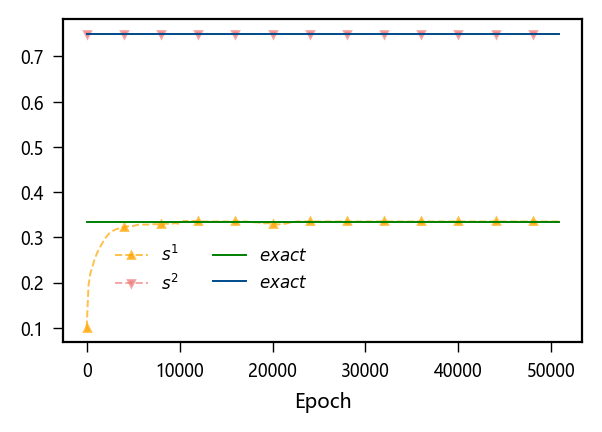

[-0.1    0.335  0.75   1.1   -0.364 -2.5   -4.72 ]
Weight [0.2397368  1.         0.07570718 0.01055794 1.        ]
Mean residual: 4.262e-02
Adding new point: [[0.75011226]] 

Adding new point: [[0.75032158]] 

Adding new point: [[0.75036774]] 

Adding new point: [[0.75043397]] 

Adding new point: [[0.75061108]] 

Adding new point: [[0.75071779]] 

Adding new point: [[0.75079511]] 

Adding new point: [[0.7508261]] 

Adding new point: [[0.75090932]] 

Adding new point: [[0.75092958]] 

Adding new point: [[0.75101006]] 

Adding new point: [[0.75109834]] 

Adding new point: [[0.75113767]] 

Adding new point: [[0.75119702]] 

Adding new point: [[0.75149339]] 

Adding new point: [[0.75169652]] 

Adding new point: [[0.75177546]] 

Adding new point: [[0.75177735]] 

Adding new point: [[0.75196058]] 

Adding new point: [[0.75200418]] 

Training model...

Step      Train loss                                            Test loss                                             Test metric
50000     [1

<Figure size 640x480 with 0 Axes>

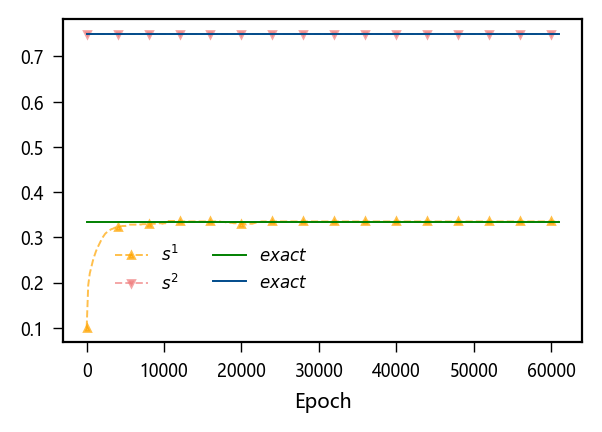

[-0.1    0.335  0.75   1.1   -0.363 -2.5   -4.73 ]
Weight [0.13858661 1.         0.05618689 0.00673534 1.        ]
Mean residual: 3.033e-02
Adding new point: [[0.74973474]] 

Adding new point: [[0.74965481]] 

Adding new point: [[0.74956081]] 

Adding new point: [[0.74948999]] 

Adding new point: [[0.74947766]] 

Adding new point: [[0.74937523]] 

Adding new point: [[0.74916961]] 

Adding new point: [[0.7491403]] 

Adding new point: [[0.7491045]] 

Adding new point: [[0.74901777]] 

Adding new point: [[0.75008497]] 

Adding new point: [[0.75013273]] 

Adding new point: [[0.75015393]] 

Adding new point: [[0.74887934]] 

Adding new point: [[0.7488611]] 

Adding new point: [[0.74885276]] 

Adding new point: [[0.74883967]] 

Adding new point: [[0.75026897]] 

Adding new point: [[0.7487323]] 

Adding new point: [[0.74868829]] 

Training model...

Step      Train loss                                            Test loss                                             Test metric
60000     [4.27

<Figure size 640x480 with 0 Axes>

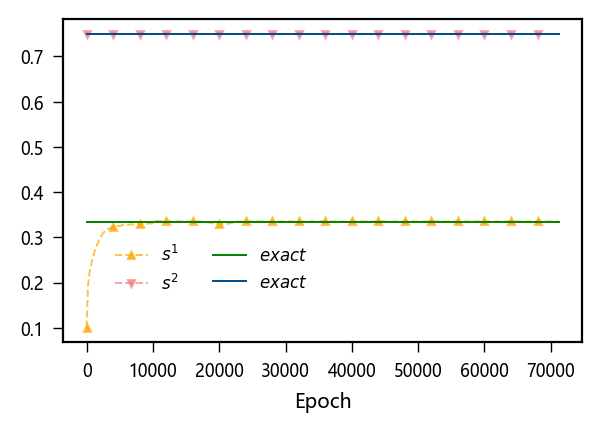

[-0.1    0.335  0.75   1.1   -0.362 -2.5   -4.74 ]
Weight [0.0870008  1.         0.06080985 0.00532952 1.        ]
Mean residual: 2.560e-02
Adding new point: [[0.74991149]] 

Adding new point: [[0.74967859]] 

Adding new point: [[0.74952007]] 

Adding new point: [[0.74950877]] 

Adding new point: [[0.74950826]] 

Adding new point: [[0.7494988]] 

Adding new point: [[0.7494955]] 

Adding new point: [[0.74932357]] 

Adding new point: [[0.74903392]] 

Adding new point: [[0.74898555]] 

Adding new point: [[0.74893898]] 

Adding new point: [[0.74868709]] 

Adding new point: [[0.74868543]] 

Adding new point: [[0.74843271]] 

Adding new point: [[0.74836303]] 

Adding new point: [[0.74817583]] 

Adding new point: [[0.74813769]] 

Adding new point: [[0.74798799]] 

Adding new point: [[0.74788139]] 

Adding new point: [[0.74760021]] 

Training model...

Step      Train loss                                            Test loss                                             Test metric
70000     [9.

<Figure size 640x480 with 0 Axes>

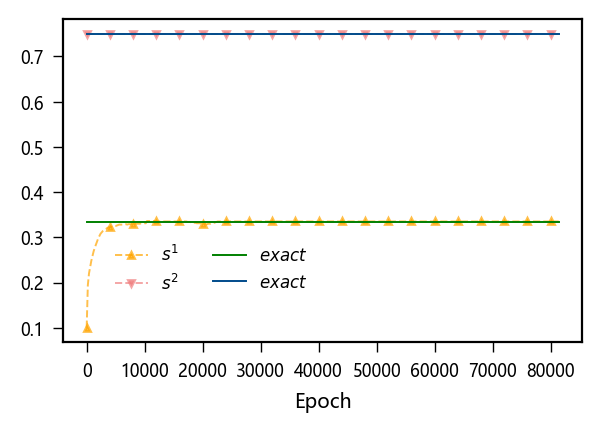

[-0.1    0.335  0.75   1.1   -0.361 -2.5   -4.74 ]
Weight [0.08770293 1.         0.06833942 0.00418252 1.        ]
Mean residual: 2.425e-02
Adding new point: [[0.7497791]] 

Adding new point: [[0.74967097]] 

Adding new point: [[0.74961593]] 

Adding new point: [[0.74952902]] 

Adding new point: [[0.74935785]] 

Adding new point: [[0.74934189]] 

Adding new point: [[0.74930251]] 

Adding new point: [[0.7492158]] 

Adding new point: [[0.7490947]] 

Adding new point: [[0.74902874]] 

Adding new point: [[0.74867639]] 

Adding new point: [[0.74844216]] 

Adding new point: [[0.74834186]] 

Adding new point: [[0.74833849]] 

Adding new point: [[0.74823083]] 

Adding new point: [[0.74821821]] 

Adding new point: [[0.74811453]] 

Adding new point: [[0.74774092]] 

Adding new point: [[0.74742607]] 

Adding new point: [[0.74731751]] 

Training model...

Step      Train loss                                            Test loss                                             Test metric
80000     [2.0

<Figure size 640x480 with 0 Axes>

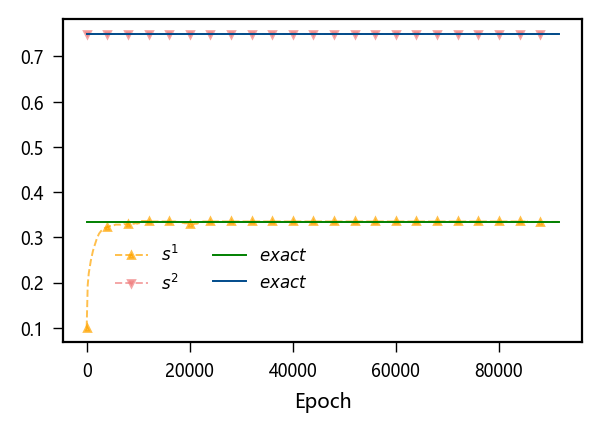

[-0.1    0.334  0.75   1.1   -0.358 -2.5   -4.74 ]
Weight [0.0939997  1.         0.07373757 0.00856834 1.        ]
Mean residual: 2.320e-02
Adding new point: [[0.74983834]] 

Adding new point: [[0.74982424]] 

Adding new point: [[0.7497145]] 

Adding new point: [[0.74962959]] 

Adding new point: [[0.74935856]] 

Adding new point: [[0.74914252]] 

Adding new point: [[0.74912148]] 

Adding new point: [[0.74901169]] 

Adding new point: [[0.74895031]] 

Adding new point: [[0.74890325]] 

Adding new point: [[0.74879226]] 

Adding new point: [[0.74878075]] 

Adding new point: [[0.74877445]] 

Adding new point: [[0.74871676]] 

Adding new point: [[0.74850871]] 

Adding new point: [[0.74846744]] 

Adding new point: [[0.74815705]] 

Adding new point: [[0.74812494]] 

Adding new point: [[0.74811475]] 

Adding new point: [[0.74809075]] 

Training model...

Step      Train loss                                            Test loss                                             Test metric
90000     [1

<Figure size 640x480 with 0 Axes>

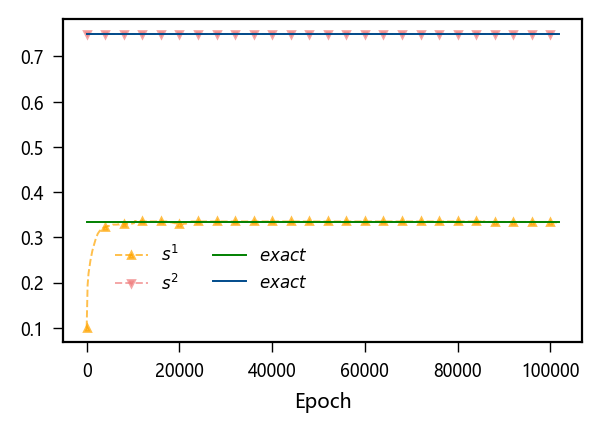

[-0.1    0.333  0.75   1.1   -0.355 -2.5   -4.74 ]


In [8]:
for i in range(6):
    Weight = np.hstack((Norm_dNN/np.max(Norm_dNN),1))
    print('Weight',Weight)
    # model.compile("adam", 1e-4, loss_weights=list(Weight.ravel()), loss = loss)
    X = np.random.uniform(0,L,10000)
    X = np.sort(X,axis = 0).reshape(-1,1)
    err_total = np.abs(model.predict(X, operator=beampde_err))  #计算前6项残差
    err_eq = np.sum(err_total,axis=0)             #每项残差除以均值进行缩放，每个点，残差求和
    print("Mean residual: %.3e" % (np.mean(err_total)))
    x_ids = np.argsort(-err_eq,axis=0 )[:20]
    for elem in x_ids:
        print("Adding new point:", X[elem], "\n")
        list_point.append(X[elem][0][0])
        data.add_anchors(X[elem])
    losshistory, train_state = model.train(epochs=10000, callbacks=[variable])
    Norm_dNN,[u,fai,M,V,Q],[fai_dNN,dfai_dNN,V_dNN,Q_dNN] = Norm_NN(X1, P = 1)
    list_Norm_dNN.append(Norm_dNN)
    list_NN.append(np.array([u,fai,M,V,Q]).reshape(5,-1).T)
    list_dNN.append(np.array([fai_dNN,dfai_dNN,V_dNN,Q_dNN]).reshape(4,-1).T)
    list_reslut = np.vstack(( list_reslut, Norm_exact() ))
    np.savetxt('1.txt', list_reslut)
    Plot_dis()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[3.33000000e-01 7.50000000e-01 4.95741044e-03 5.40595552e-03
 5.78108401e-04 1.46162136e-04 1.85795429e-04]


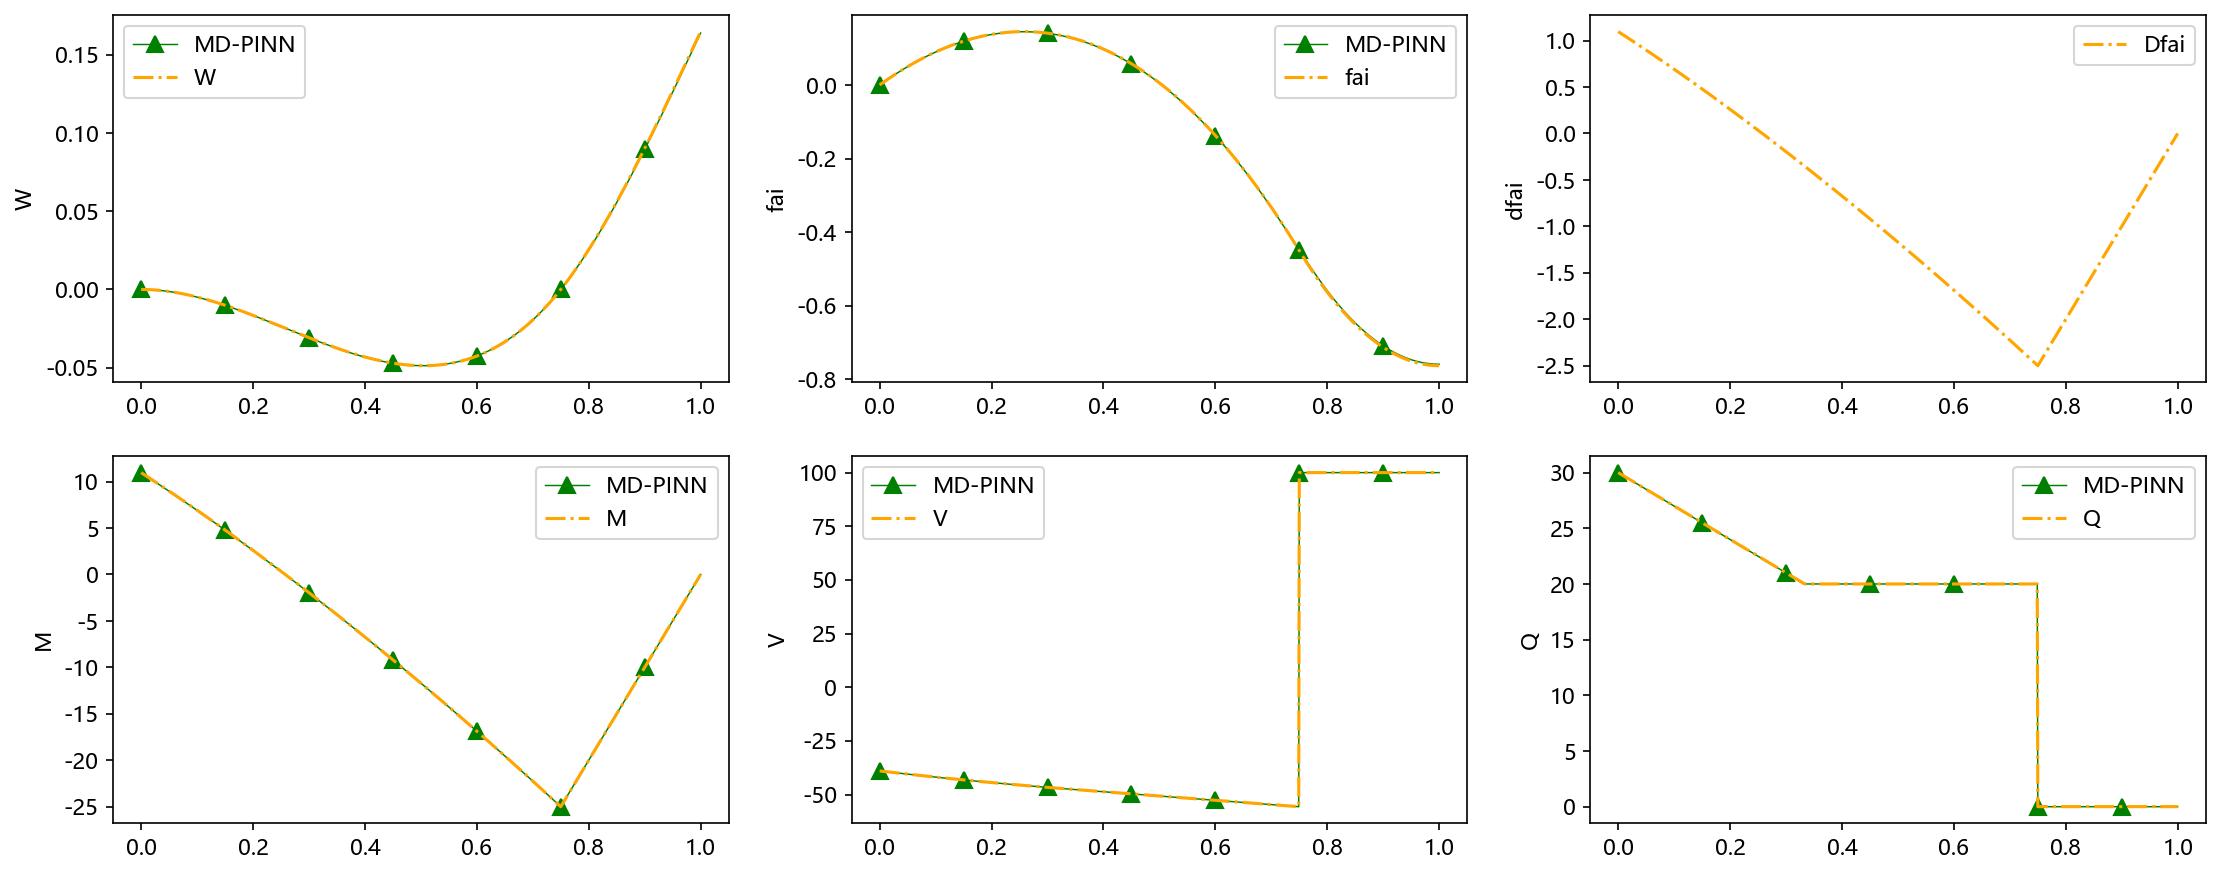

In [10]:
Norm,[W,Fai,M,V,Q] = Norm_exact(P =1)
plt.rcParams.update({'font.size': 10.5})
markersize=8
markevery=150
X2 = X1
plt.figure(figsize=(18,7),dpi=150)
plt.subplot(2,3,1)
plt.plot(X2, W, label='MD-PINN',color='green',marker='^',markersize=markersize,markevery=markevery,linewidth=0.7)
plt.ylabel('W')
plt.legend()

plt.subplot(2,3,2)
plt.plot(X2, fai, label='MD-PINN',color='green',marker='^',markersize=markersize,markevery=markevery,linewidth=0.7)
plt.ylabel('fai')
plt.legend()

plt.subplot(2,3,3)
plt.plot(X2, dfai_dNN, label='MD-PINN',color='green',marker='^',markersize=markersize,markevery=markevery,linewidth=0.7)
plt.ylabel('dfai')
plt.legend()

plt.subplot(2,3,4)
plt.plot(X2, M, label='MD-PINN',color='green',marker='^',markersize=markersize,markevery=markevery,linewidth=0.7)
plt.ylabel('M')
plt.legend()

plt.subplot(2,3,5)
plt.plot(X2, V, label='MD-PINN',color='green',marker='^',markersize=markersize,markevery=markevery,linewidth=0.7)
plt.ylabel('V')
plt.legend()

plt.subplot(2,3,6)
plt.plot(X2, Q, label='MD-PINN',color='green',marker='^',markersize=markersize,markevery=markevery,linewidth=0.7)
plt.ylabel('Q')
plt.legend()



plt.subplot(2,3,1)
# plt.vlines(0.75,-0.05,0.15)
# plt.hlines(0,0.6,0.8)
plt.plot(X1,WW1,label="W", linestyle='dashdot', color='orange')
plt.legend()
plt.subplot(2,3,2)
plt.plot(X1,dWW1,label="fai", linestyle='dashdot', color='orange')
plt.legend()

plt.subplot(2,3,3)
plt.plot(X1,dfai_real,label="Dfai", linestyle='dashdot', color='orange')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(X1,ddWW1,label="M", linestyle='dashdot', color='orange')
plt.legend()
plt.subplot(2, 3, 5)
plt.plot(X1,dddWW1,label="V", linestyle='dashdot', color='orange')
plt.legend()
plt.subplot(2, 3, 6)
plt.plot(X1,ddddWW1,label="Q", linestyle='dashdot', color='orange')
plt.legend()